# 의사결정나무

In [2]:
import pandas as pd
import numpy as np 
import warnings
import matplotlib
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

plt.rc('font',family = 'Malgun Gothic')
matplotlib.rc("axes",unicode_minus = False) # 음수표시 

In [3]:
df_raw = pd.read_csv("./실습화일/2. Big Data 분석/HMEQ.csv",encoding='euc-kr')

df_raw["JOB"].fillna("Other",inplace = True)

#결측치 평균으로 대체
df_raw.fillna(df_raw.mean(),inplace=True)

#데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
#생성된 더미변수 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [4]:
#설명,목표 변수 데이터 구분
df_raw_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["BAD"]
#데이터 분할
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size = 0.3,random_state=1234)
print("분할 전 설명변수 데이터:",df_raw_x.shape)
print("분할 후 설명변수 데이터:Train",df_train_x.shape,"Test",df_test_x.shape)

분할 전 설명변수 데이터: (3748, 18)
분할 후 설명변수 데이터:Train (2623, 18) Test (1125, 18)


# 오버샘플링

BAD
0      3403
1       345
dtype: int64 

BAD=1 비율 BAD
False    0.907951
True     0.092049
dtype: float64


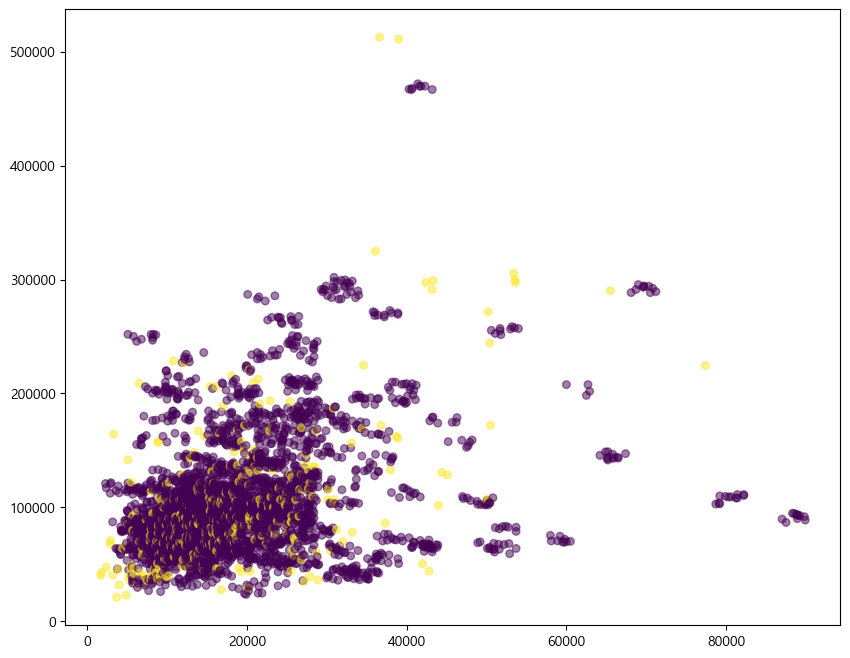

In [5]:
from imblearn.over_sampling import SMOTE
#목표변수 빈도 확인
print(df_raw.value_counts(["BAD"]),"\n")
print("BAD=1 비율",df_raw.value_counts(df_raw["BAD"]==1)/len(df_raw))
#목표변수 산점도 확인
plt.figure(figsize = (10,8))
plt.scatter(df_raw['LOAN'],df_raw['VALUE'],c=df_raw['BAD'],s=30,alpha=0.5)
plt.show()

In [6]:
# over-sampling 설정 ( 1 의 비율이 9.2%로 매우 적음)
sm = SMOTE(sampling_strategy='auto')
# train데이터를 이용한 Over-sampling
x_resampled,y_resampled = sm.fit_resample(df_train_x,df_train_y)
#결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {}\n'.format(y_resampled.shape))
print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 0    2382
1     241
Name: BAD, dtype: int64 

Over-Sampling 후 Train X: (4764, 18)
Over-Sampling 후 Train Y: (4764,)

Over-Sampling 후 '1':2382
Over-Sampling 후 '0':2382


    LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
0  27600   103898  130784.0  11.0      0     0.0  147.128398   0.0    29   
1  30200    80951  116160.0  19.0      4     0.0  130.360362   0.0    58   
2   5700    74172   79846.0   0.0      0     0.0  157.009775   0.0    28   
3  14900    22245   31531.0   7.0      0     0.0   91.074218   0.0    16   
4  30500    57516  103086.0   3.0      0     0.0  166.199527   2.0    24   

     DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  JOB_Other  \
0  42.009814               1               0        0           1          0   
1  50.352999               1               0        0           0          0   
2  47.415229               1               0        0           0          0   
3  21.620580               1               0        0           1          0   
4  37.814089               1               0        0           1          0   

   JOB_ProfExe  JOB_Sales  JOB_Self  BAD  
0            0     

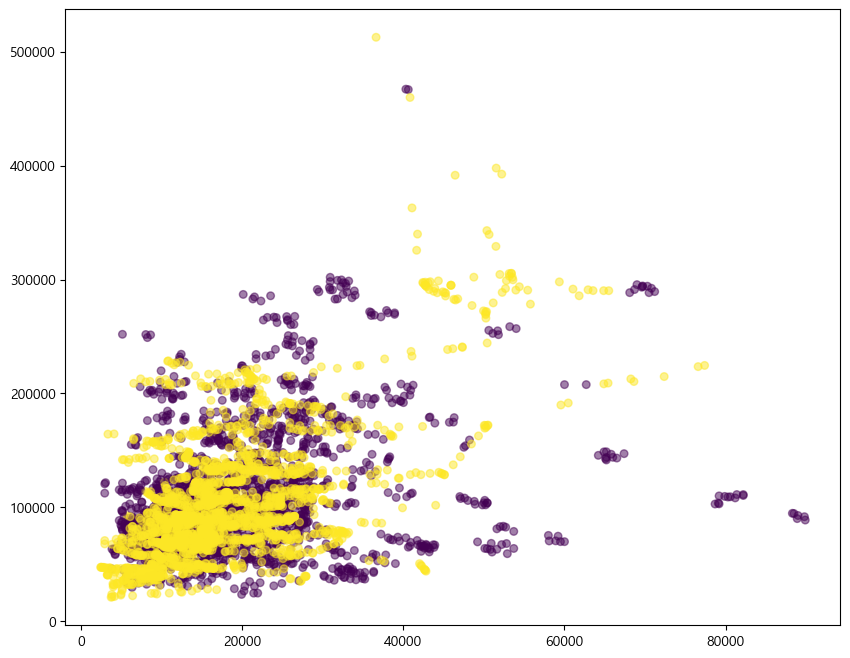

In [7]:
#데이터 결합
df_resampled = pd.concat([x_resampled,y_resampled], axis = 1)
print(df_resampled.head())
#목표변수 산점도 확인
plt.figure(figsize = (10,8))
plt.scatter(df_resampled['LOAN'],df_resampled['VALUE'],
           c=df_resampled['BAD'],s=30,alpha=0.5)
plt.show()

# 불균형 데이터 모델링

In [8]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)
#train모델 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x,df_train_y)))
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.932


In [9]:
#생성된 모델의 옵션 확인
print(tree_uncustomized.get_params().keys())
print(tree_uncustomized.get_params().values())

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])
dict_values([0.0, None, 'gini', None, None, None, 0.0, 1, 2, 0.0, 1234, 'best'])


In [10]:
#train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy =[]
#max_depth:최대깊이 변경:1~10
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state =1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [11]:
#모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.926,0.924
1,2,0.931,0.927
2,3,0.934,0.921
3,4,0.937,0.928
4,5,0.940,0.930
5,6,0.941,0.930
6,7,0.947,0.935
7,8,0.951,0.933
8,9,0.957,0.933
9,10,0.960,0.938


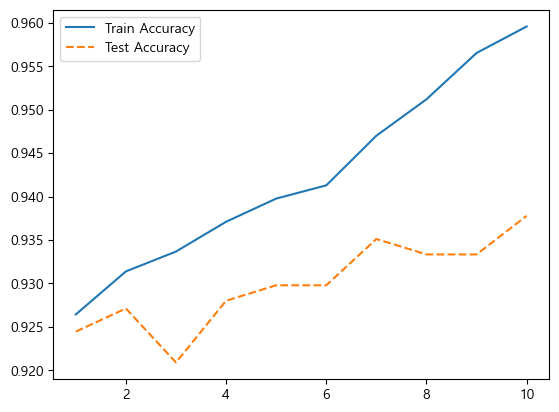

In [12]:
#모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy,linestyle='-',label = 'Train Accuracy')
plt.plot(para_depth, test_accuracy,linestyle='--',label = 'Test Accuracy')
plt.legend()

### 최대 깊이 파라미터는 지정 값의 최대이지 필요조건은 아님

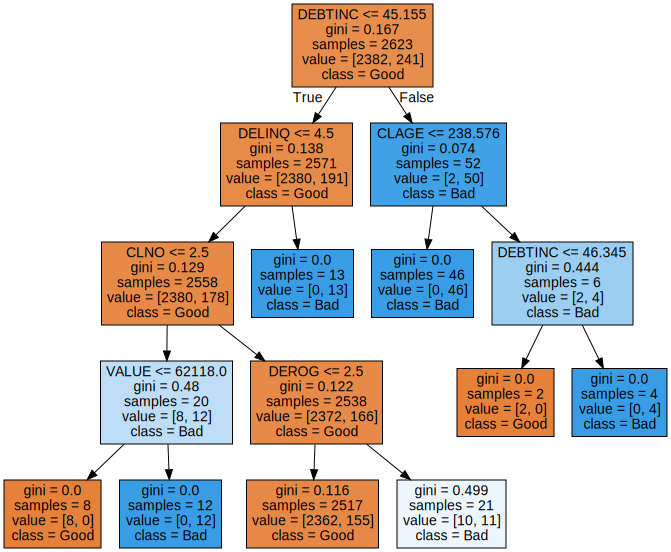

In [13]:
#변수명 저장
v_feature_name = df_train_x.columns
#깊이가 4인 모델
tree_low = DecisionTreeClassifier(max_depth = 4, random_state=1234)
tree_low.fit(df_train_x,df_train_y)
#트리 모델을 tree_low.dot파일로 저장.(목표변수,0:good,1:bad)
export_graphviz(tree_low,out_file='tree_low.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_low.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

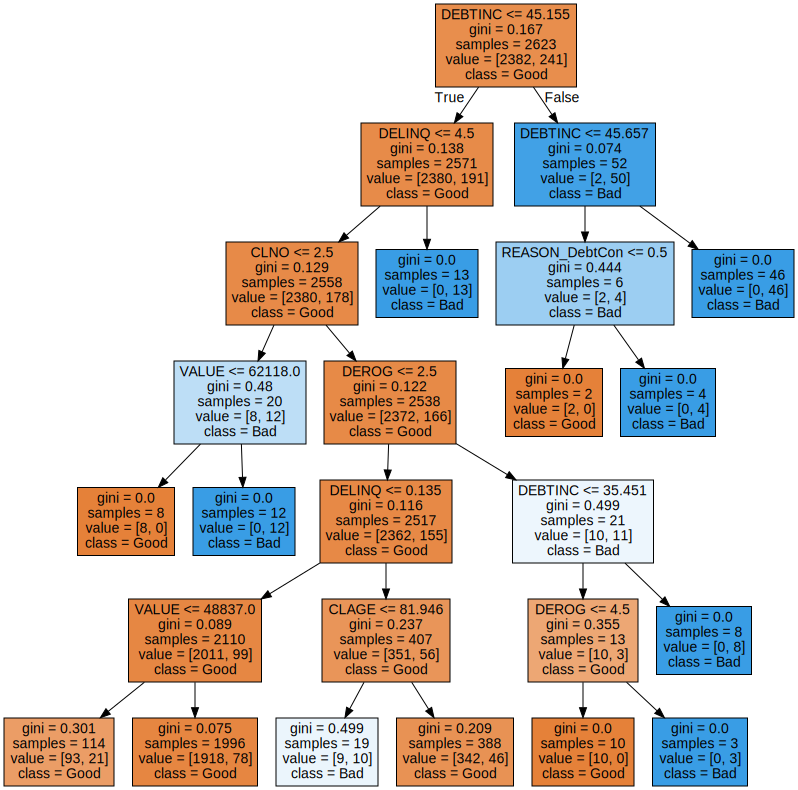

In [14]:
#깊이가 6인 모델
tree_high = DecisionTreeClassifier(max_depth = 6, random_state=1234)
tree_high.fit(df_train_x,df_train_y)
#트리 모델을 tree_low.dot파일로 저장.(목표변수,0:good,1:bad)
export_graphviz(tree_high,out_file='tree_high.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_high.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [15]:
#train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy =[]
#max_depth:최대깊이 변경:1~10
para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split,
                                  max_depth = 6, random_state =1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["Depth"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [16]:
#모델 정확도 확인
df_accuracy_split.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,10,0.941,0.929
1,20,0.939,0.926
2,30,0.934,0.918
3,40,0.934,0.918
4,50,0.934,0.918
5,60,0.934,0.918
6,70,0.934,0.918
7,80,0.934,0.918
8,90,0.934,0.918
9,100,0.934,0.918


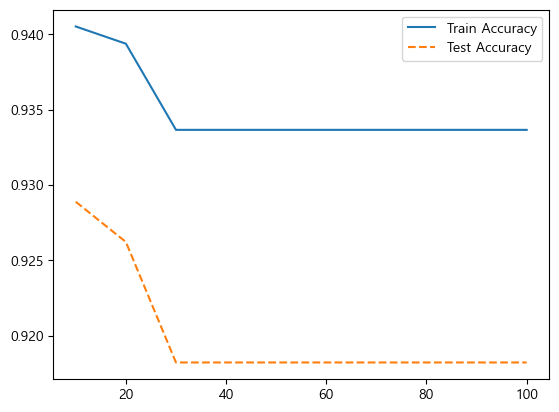

In [17]:
#모델 정확도 그래프 확인
plt.plot(para_split, train_accuracy,linestyle='-',label = 'Train Accuracy')
plt.plot(para_split, test_accuracy,linestyle='--',label = 'Test Accuracy')
plt.legend()

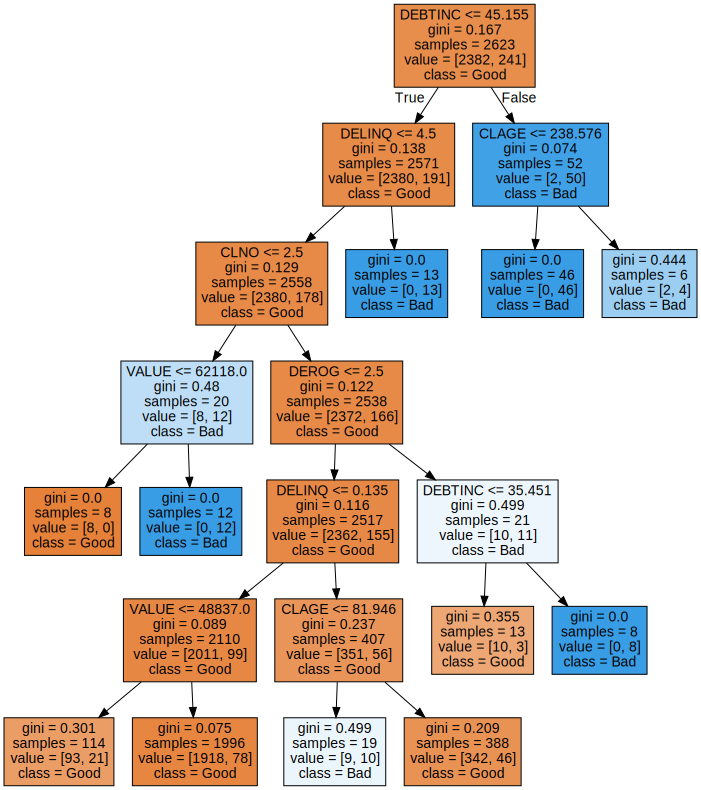

In [18]:
#분리 노드의 최소 자료 수가 20인 모델
tree_low = DecisionTreeClassifier(max_depth = 6, min_samples_split = 20, random_state=1234)
tree_low.fit(df_train_x,df_train_y)
#트리 모델을 tree_low.dot파일로 저장.(목표변수,0:good,1:bad)
export_graphviz(tree_low,out_file='tree_low.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_low.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

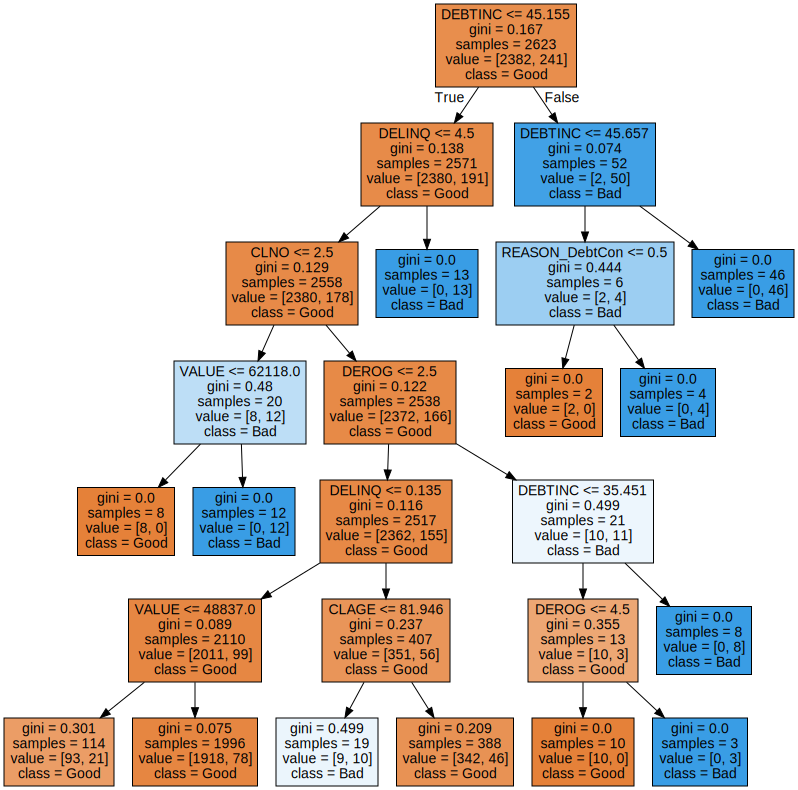

In [19]:
#분리 노드의 최소 자료 수가 30인 모델
tree_high = DecisionTreeClassifier(max_depth = 6, min_samples_split = 30, random_state=1234)
tree_high.fit(df_train_x,df_train_y)
#트리 모델을 tree_low.dot파일로 저장.(목표변수,0:good,1:bad)
export_graphviz(tree_high,out_file='tree_low.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_high.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [20]:
#min_sample_leaf 조정
#train, test 정확도 결과 저장용
train_accuracy = []; test_accuracy =[]
#max_depth:최대깊이 변경:1~10
para_leaf = [n_leaf * 2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf,
                                  min_samples_split = 20,
                                  max_depth = 6, random_state =1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["Depth"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

#모델 정확도 확인
df_accuracy_leaf.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,2,0.939,0.926
1,4,0.939,0.926
2,6,0.939,0.926
3,8,0.939,0.926
4,10,0.938,0.927
5,12,0.934,0.918
6,14,0.932,0.917
7,16,0.932,0.919
8,18,0.932,0.919
9,20,0.932,0.919


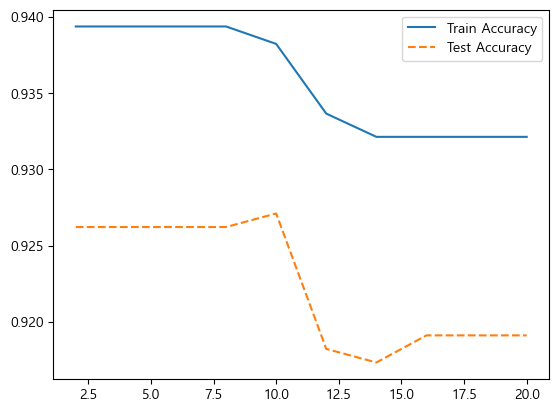

In [21]:
#모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy,linestyle='-',label = 'Train Accuracy')
plt.plot(para_leaf, test_accuracy,linestyle='--',label = 'Test Accuracy')
plt.legend()

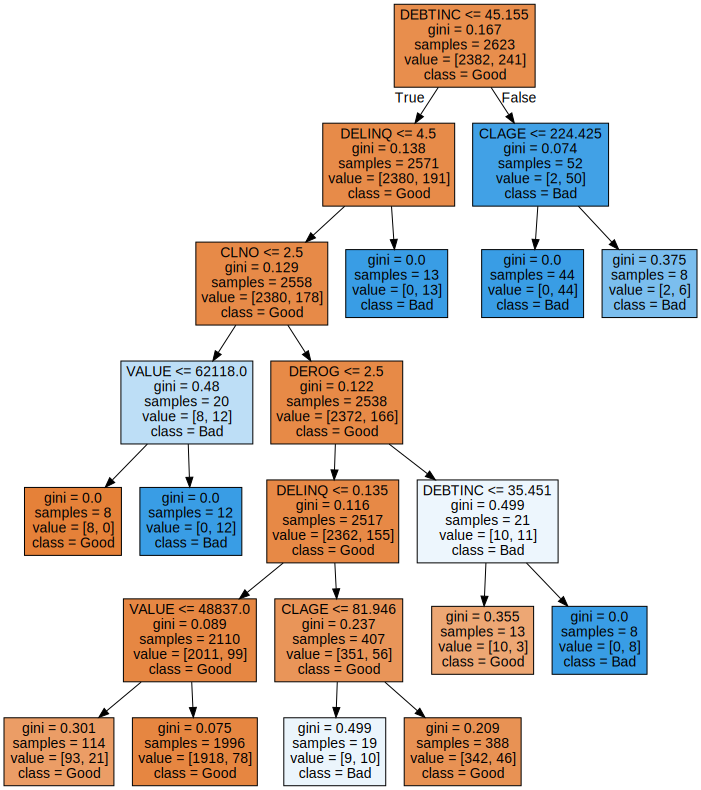

In [22]:
#잎사귀의 최소 자료 수가 8인 모델
tree_low = DecisionTreeClassifier(max_depth = 6, min_samples_split = 20,
                                  min_samples_leaf=8, random_state=1234)
tree_low.fit(df_train_x,df_train_y)
#트리 모델을 tree_low.dot파일로 저장.(목표변수,0:good,1:bad)
export_graphviz(tree_low,out_file='tree_low.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_low.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

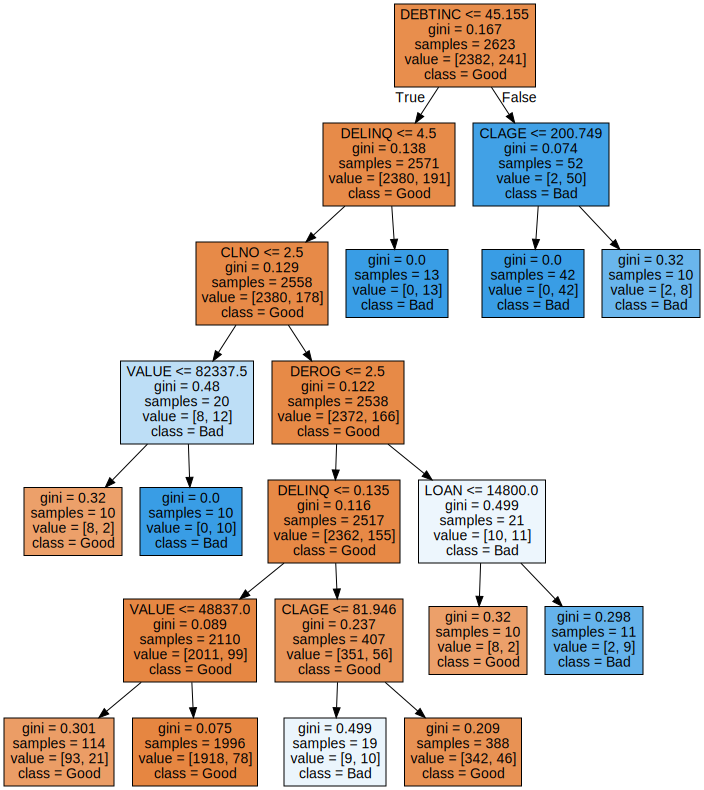

In [23]:
#잎사귀의 최소 자료 수가 10인 모델
tree_high = DecisionTreeClassifier(max_depth = 6, min_samples_split = 20, 
                                   min_samples_leaf = 10, random_state=1234)
tree_high.fit(df_train_x,df_train_y)
#트리 모델을 tree_low.dot파일로 저장.(목표변수,0:good,1:bad)
export_graphviz(tree_high,out_file='tree_high.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_high.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [24]:
#최종 모델 선정
tree_final = DecisionTreeClassifier(max_depth = 6, min_samples_split = 20, min_samples_leaf = 10, random_state = 1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=20,
                       random_state=1234)

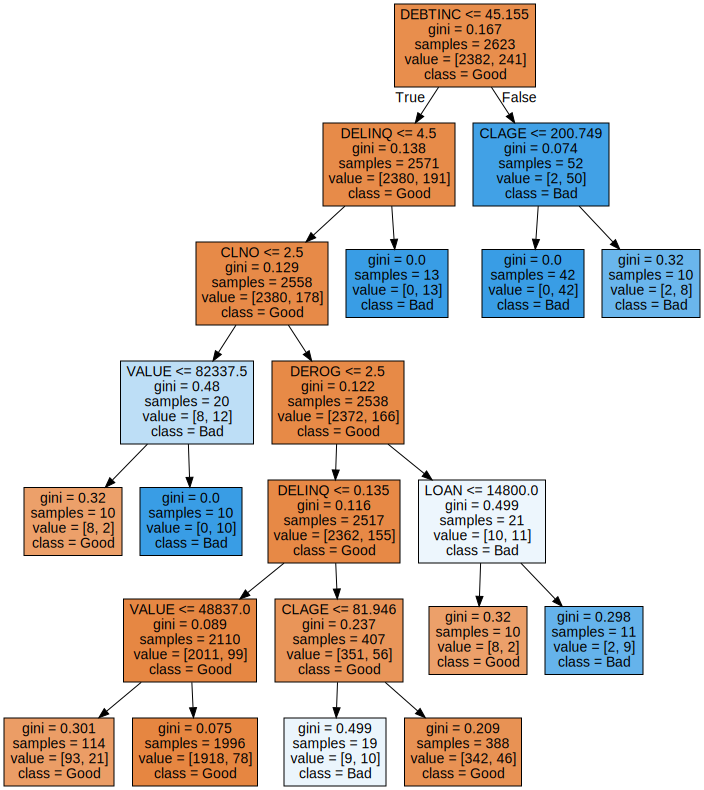

In [25]:
export_graphviz(tree_final,out_file='tree_final.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_final.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [26]:
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x,df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

print(classification_report(df_test_y,y_pred,digits=3))

Accuracy: 0.927

Confusion matrix:
[[1013    8]
 [  74   30]]
              precision    recall  f1-score   support

           0      0.932     0.992     0.961      1021
           1      0.789     0.288     0.423       104

    accuracy                          0.927      1125
   macro avg      0.861     0.640     0.692      1125
weighted avg      0.919     0.927     0.911      1125



In [27]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance =pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

#df_feature_importance의 테이브ㄹ을 중요도 순으로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.535
5,DELINQ,0.187
8,CLNO,0.076
2,VALUE,0.073
4,DEROG,0.059
6,CLAGE,0.044
0,LOAN,0.027
7,NINQ,0.000
3,YOJ,0.000
1,MORTDUE,0.000


Text(0, 0.5, '설명변수')

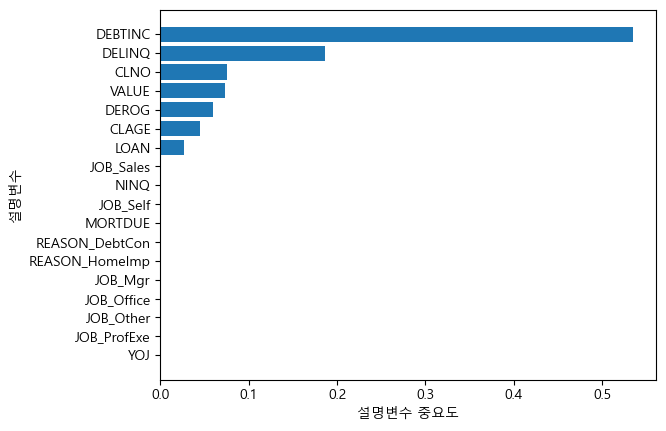

In [28]:
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

# Over-Sampling 데이터 모델링

In [34]:
# stratify=y_resampled : 클래스 비율을 y_resampled 그대로 유지하면서 분할 매개변수
df_train_x_over,df_test_x_over,df_train_y_over,df_test_y_over = train_test_split(
    x_resampled,y_resampled,test_size = 0.3,stratify=y_resampled, random_state=1234)
print("분할 전 데이터  설명:",x_resampled.shape,"목표:",y_resampled.shape)
print("분할 후 설명변수 :Train",df_train_x_over.shape,"Test:",df_test_x_over.shape)
print("분할 후 목표변수 :Train",df_train_y_over.shape,"Test:",df_test_y_over.shape)

분할 전 데이터  설명: (4764, 18) 목표: (4764,)
분할 후 설명변수 :Train (3334, 18) Test: (1430, 18)
분할 후 목표변수 :Train (3334,) Test: (1430,)


In [35]:
#최종 모델 선정
tree_final_over = DecisionTreeClassifier(max_depth = 6, min_samples_split = 20, min_samples_leaf = 10, random_state = 1234)
tree_final_over.fit(df_train_x_over,df_train_y_over)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=20,
                       random_state=1234)

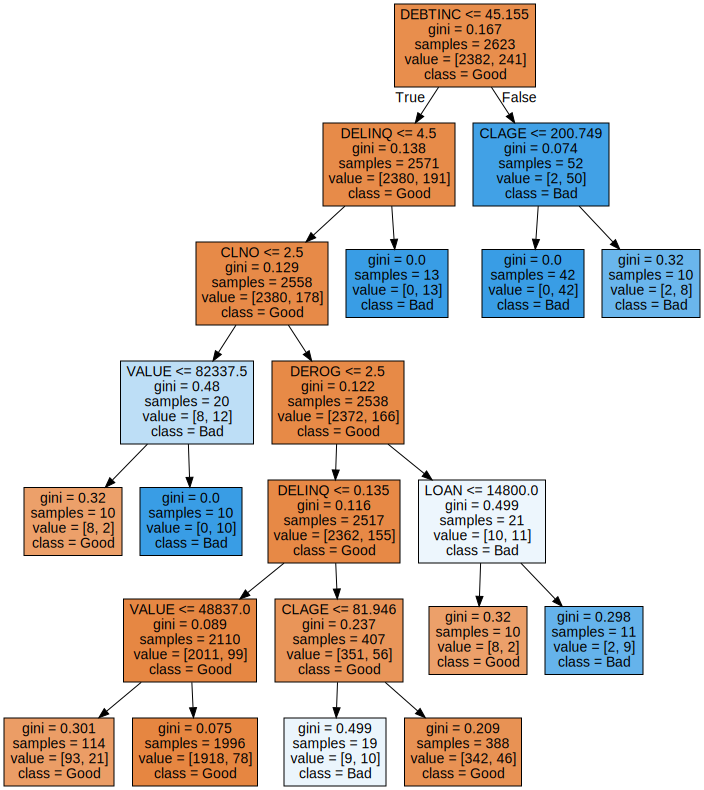

In [36]:
export_graphviz(tree_final_over,out_file='tree_final_over.dot',class_names=['Good','Bad'],
               feature_names = v_feature_name, impurity = True, filled = True)
#graphviz를 이용해 트리 모델 시각화
with open('tree_final.dot')as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [37]:
y_pred_over = tree_final_over.predict(df_test_x_over)
print("Accuracy: {0:.3f}\n".format(tree_final_over.score(df_test_x_over,df_test_y_over)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y_over,y_pred_over)))

print(classification_report(df_test_y_over,y_pred_over,digits=3))

Accuracy: 0.827

Confusion matrix:
[[681  34]
 [213 502]]
              precision    recall  f1-score   support

           0      0.762     0.952     0.846       715
           1      0.937     0.702     0.803       715

    accuracy                          0.827      1430
   macro avg      0.849     0.827     0.825      1430
weighted avg      0.849     0.827     0.825      1430



test 모델의 정확도는 82.7% (정확도가 낮아짐 - 깊이 조정, 데이터 구조 변경)

"1" 기준 f1-score 는 82.7% (precision 과 recall 이 유사)

precision과 recall 이 유사하여 불균형 자료 대비 f1-score 높아짐

In [38]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance =pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance'] = tree_final_over.feature_importances_

#df_feature_importance의 테이브ㄹ을 중요도 순으로 정렬
df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)

,Feature,Importance
5,DELINQ,0.525
9,DEBTINC,0.188
2,VALUE,0.092
6,CLAGE,0.082
8,CLNO,0.027
13,JOB_Office,0.019
15,JOB_ProfExe,0.018
7,NINQ,0.017
3,YOJ,0.015
11,REASON_HomeImp,0.009


Text(0, 0.5, '설명변수')

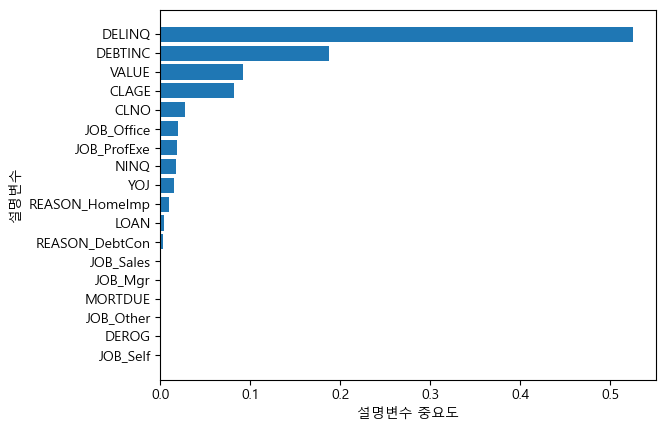

In [39]:
df_importance.sort_values('Importance',ascending=True,inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates,width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

In [42]:
estimator = DecisionTreeClassifier()
param_grid = {"max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}

# 정확도가 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring = "accuracy", n_jobs=-1)
grid_dt.fit(df_train_x,df_train_y)

print("best estimator model:\n{}".format(grid_dt.best_estimator_))
print("\nbest parameter:\n{}".format(grid_dt.best_params_))
print("\nbest score:\n{}".format(grid_dt.best_score_))

best estimator model:
DecisionTreeClassifier(max_depth=9, min_samples_leaf=4, min_samples_split=10)

best parameter:
{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}

best score:
0.9355776081424937
